<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_STFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Velkommen til SRP øvelsen i Forbedring af talesignal ved brug af støjreduktion

Talesignaler kan ofte være svære at forstå hvis der samtidigt forekommer støj. I dagens øvelser vil vi undersøge nogle af de teknikker der ligger til grund for den signalbehandling og støjreduktion, som bl.a. bruges i høreapparater.

I først del af denne øvelse vil vi starte med at introducere Google Colab som er det udviklingsmiljø vi skal arbejde med. Colab er et online programmerings miljø hvor almindelig tekst (som læses her) kan kombineres med Python kode og widgets.

Øvelserne består af en række interaktive figurer hvor signalbehandlingsparametre kan styres, og hvortil lyden både kan afspilles og visualiseres.

I dagens program har vi tre hovedøvelser

1. **Analyse af signaler i tid og frekvens**

I denne øvelse vil vi analysere tale, musik, og støjsignaler ved brug af spektrogrammet. I vil lære at kende de primære forskelle på tid og frekvensrepræsentationer af signaler, og hvordan repræsentationerne kan kombineres. Vi vil undersøge hvilke elementer talesignaler består af og hvordan de kan identificeres på spektrogrammer.


2. **Signalbehandling ved brug af STFT**

I øvelse 2 vil vi ved brug af digital signalbehandling fjerne uønskede dele af et lydmix. Dette gøres ved frekvensfiltrering i en tid-frekvensrepræsentation af et signal. Vi undersøger principperne ved højpas, lavpas, båndpas, og båndpas filtre og hvilke begrænsninger de har.

3. **Støjreduktion**

I øvelse 3 undersøger vi hvordan støj kan fjernes fra et mix. Vi vil starte med at arbejde med lydniveauer og signal-støjforhold, og herefter benytte thresholding metoden til at fjerne støj. Vi vil evaluerer metoden ved at måle signal-støjforholdet før og efter.



In [1]:
#@title Setup
#@markdown Tryk på pilen for at hente de nødvendige hjælpefilter og starte Colab serveren
!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum


fatal: destination path 'SRP2021' already exists and is not an empty directory.


# Del 1: Talesignaler i tid og frekvens

Mennesker har en særlig evne til at forme lyde om til tale og sprog. Dette er en af de fundamentale aspekter for kommunikation, da vi ved at lytte til talesignaler kan genskabe de ord og sætninger som blev ytret.

Dette kan lade sig gøre, fordi hvert ord består af forskellige lyde som vi mennesker både kan udtrykke og samtidigt opfatte. Den allermindste indelling af lyde kaldes fonemer. For eksempel er fonemet [a] svarende til a'et i ordet *havde* og fonemet [$\alpha$] er a'et i ordet *har*.

Sammen med alle de andre fonemer som beskriver bogstaverne *A, E, I, O, Y, Æ, Ø ,Å*, er både [a] og [$\alpha$] vokaler. Vokaler dannes ved at en enkelt tone skabes i stemmeapparatet og ændres gennem mundens udformning og tungens position. Toner er gentagende bølger, og vokaler kan derfor genkendes ved at de består af specifikke frekvenser.

Konsonanter er en større gruppering af lyde, som for eksempel */t/, /sh/, /p/* osv. I modsætning til vokaler består konsonanter ofte af mange vidt forskellige frekvenser. 

Nogle konsonanter fremstilles ved at opbygge et lufttryk som kort efter frigives (/p/ med læberne eller /d/ med tungen), disse kaldes plosiver og stops. 

En anden type konsonanter er frikativer, som for eksempel */f/* og */sh/*. Frikativer består i at luftvejen bliver forhindret, men ikke blokeret.  

En type af konsonanter som er beslægtet med vokaler er *nasal* lyde, såsom */n/* og */m/*. Disse produceres med toner skabt af stemmebåndet, mens munden er lukket. 



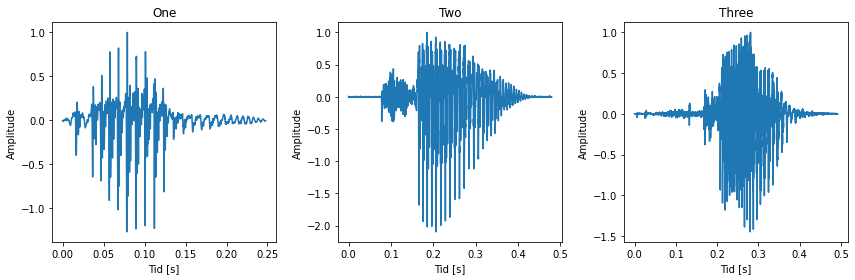

In [2]:
#@title Tidsrepræsentation
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if 'lucas' in f]))

titles = ["One","Two","Three"]

plt.figure(figsize=(12,4))
for i in range(3):
  x, fs = utils.getAudio(audioDir + audioFiles[i+1])

  t = np.arange(len(x.T))/fs
  plt.subplot(1,3,i+1)
  plt.plot(t,x.T/x.max())
  plt.title(titles[i])
  plt.xlabel("Tid [s]")
  plt.ylabel("Amplitude")

  display(utils.play(x,fs))
plt.tight_layout()
plt.show()
  



* I figurene ovenfor ses tre bølgeforme, beskriv 
* Beskriv udfra bølgeformen forskellen på vokal-lyden /o/ og nasal-lyden /n/ i ordet *one*
* Beskriv forskellen på /t/ og /u/ lydende i ordet *Two*. 

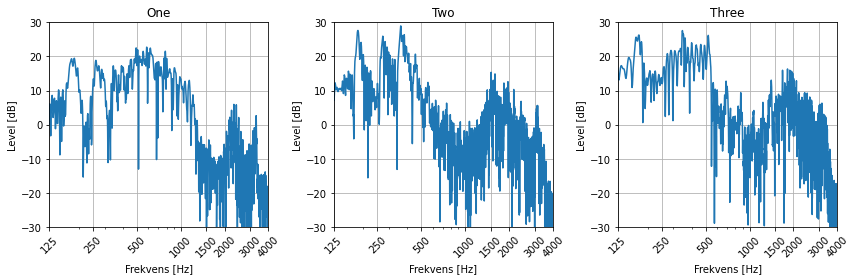

In [3]:
#@title Frekvensspektrum
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if 'lucas' in f]))

titles = ["One","Two","Three"]

fft = spectrum.FFT(N=8000,fs=fs)

plt.figure(figsize=(12,4))
for i in range(3):
  x, fs = utils.getAudio(audioDir + audioFiles[i+1])

  X = fft.transform(x)
  plt.subplot(1,3,i+1)
  plt.semilogx(fft.f,(20*np.log10(np.abs(X.T))))
  plt.title(titles[i])
  plt.ylabel("Level [dB]")
  plt.xlabel("Frekvens [Hz]")
  plt.xlim([200,4000])
  plt.xticks([125,250,500,1000,1500,2000,3000,4000],[125,250,500,1000,1500,2000,3000,4000],rotation=45)
  plt.ylim([-30,30])
  
  plt.grid()
plt.tight_layout()
plt.show()
  



Ved frekvensanalyse kan frekvenserne af et signal identificeres. Dette kan bruges til for eksempelvis at finde grundtonen af en lyd. I ovenstående figure kan det ses at det meste of frekvens indholdet for de tre ord er mellem 125 og 1000 Hz.

* Hvilke forskelle er der på de tre signaler?
* Både bølgeforme og frekvensspektre kan bruges til at analysere signaler, men hvad er de væsentligeste forskelle på de to repræsentationer? 



## Spektrogrammet


En metode til at analysere et signal i både tid og frekvens er ved hjælp af spektrogrammet. Spektrogrammet består af at dele et tidssignal op i mindre stykker, også kaldet *frames*, hvor frekvensspektret beregnes i hver frame.




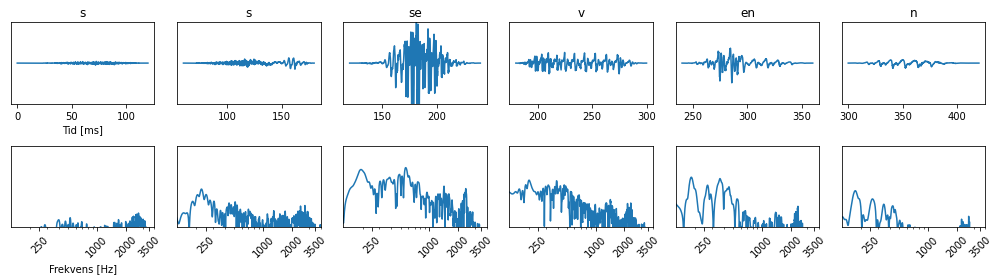

In [4]:
#@title Eksempel på sekventering
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if '7_' in f]))
titles = ["One",]

x, fs = utils.getAudio(audioDir + audioFiles[0])
x = x/np.max(x)

frames = processing.Frames(fs=fs,frame_ms=120)

xframes = frames.transform(x)
w = np.hanning(xframes.shape[-1])
t = np.arange(len(xframes[0,0]))/fs

titles = ['s','s','se','v','en','n']

plt.figure(figsize=(14,4))
for i in range(6):
  plt.subplot(2,6,i+1)
  plt.plot(t*1e3+i*60,xframes[0,i]*w)
  plt.ylim([-1,1])
  plt.yticks([])
  plt.title(titles[i])

  display(utils.play(xframes[0,i],fs))
  if i == 0:
    plt.xlabel('Tid [ms]')


  X = fft.transform(xframes[0,i]*w)
  plt.subplot(2,6,i+1+6)
  plt.semilogx(fft.f,(20*np.log10(np.abs(X.T))))
  plt.xlim([125,4000])
  plt.xticks([250,1000,2000,3500],[250,1000,2000,3500],rotation=45)
  plt.ylim([-10,50])
  plt.yticks([])

  if i == 0:
    plt.xlabel('Frekvens [Hz]')

plt.tight_layout()

Ovenfor er ordet *seven* sekventeret i overlappende stykker med en varighed på 120ms hver. Et spektrogram er lavet på nøjagtig samme princip, med undtagelsen af at frekvensanalysen ofte er lavet i meget kortere frames (for eksempel 32ms) og overlappet mellem frames vil være højere (for eksempel 75% overlap).

Ved at sætte sekvenserne efterfulgt af hinanden kan frekvensindholdet over tid vises. På denne måde kan tid og frekvensindholdet vises i en enkelt figur. Oftest vises dette ved at lade x-aksen være tids-aksen, y-aksen være frekvens-aksen, mens farveintenstiteten viser lydniveauet for hver frekvens.


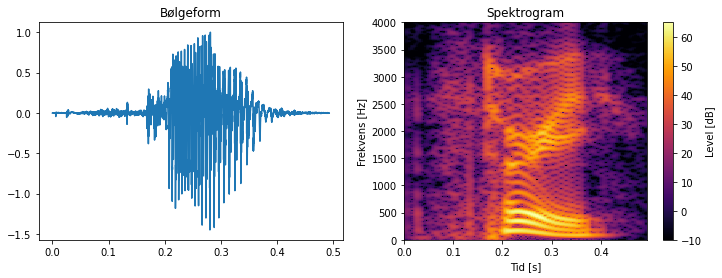

In [7]:
#@title Tal fra 0 til 9 {run: "auto"}

digit = "3" #@param ["0","1","2","3"]
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if 'lucas' in f]))
digitFile = audioDir+audioFiles[int(digit)]

x,fs = utils.getAudio(digitFile)
x = processing.normalize().transform(x)

t = np.arange(len(x.T))/fs

stft = spectrum.STFT(fs=fs,nperseg=256,nfft=4,noverlapratio=0.9)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x.T/x.max())
plt.title("Bølgeform")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=-10,vmax=65,cmap='inferno')
plt.ylim([0,4e3])
plt.title("Spektrogram")
plt.ylabel("Frekvens [Hz]")
plt.xlabel("Tid [s]")
cbar = plt.colorbar()
cbar.set_label("Level [dB]")
plt.show()

display(utils.play(x,fs))

* Beskriv hvordan du forstår spektrogrammet
  * Hvad betyder farverne?
  * Hvad betyder en horizontal linje?
  * Hvad betyder en skarp vertikal linje?
  * Hvorfor er nogle af linjerne lysere end andre?

* Inspicer tallene Zero, One, Two, Three. Prøv at beskriv forskellene i følgende ud fra spektrogrammerne.
  * **Vokaler** (*/e/ og /o/* i zero) og **nasallyde** (*/n/* i one)
  * **Frikativer** (*/z/, /th/* i zero og three) og **Plosiver** (*/t/* i two)




# Quiz

Hvilket tal viser spektrogrammet?

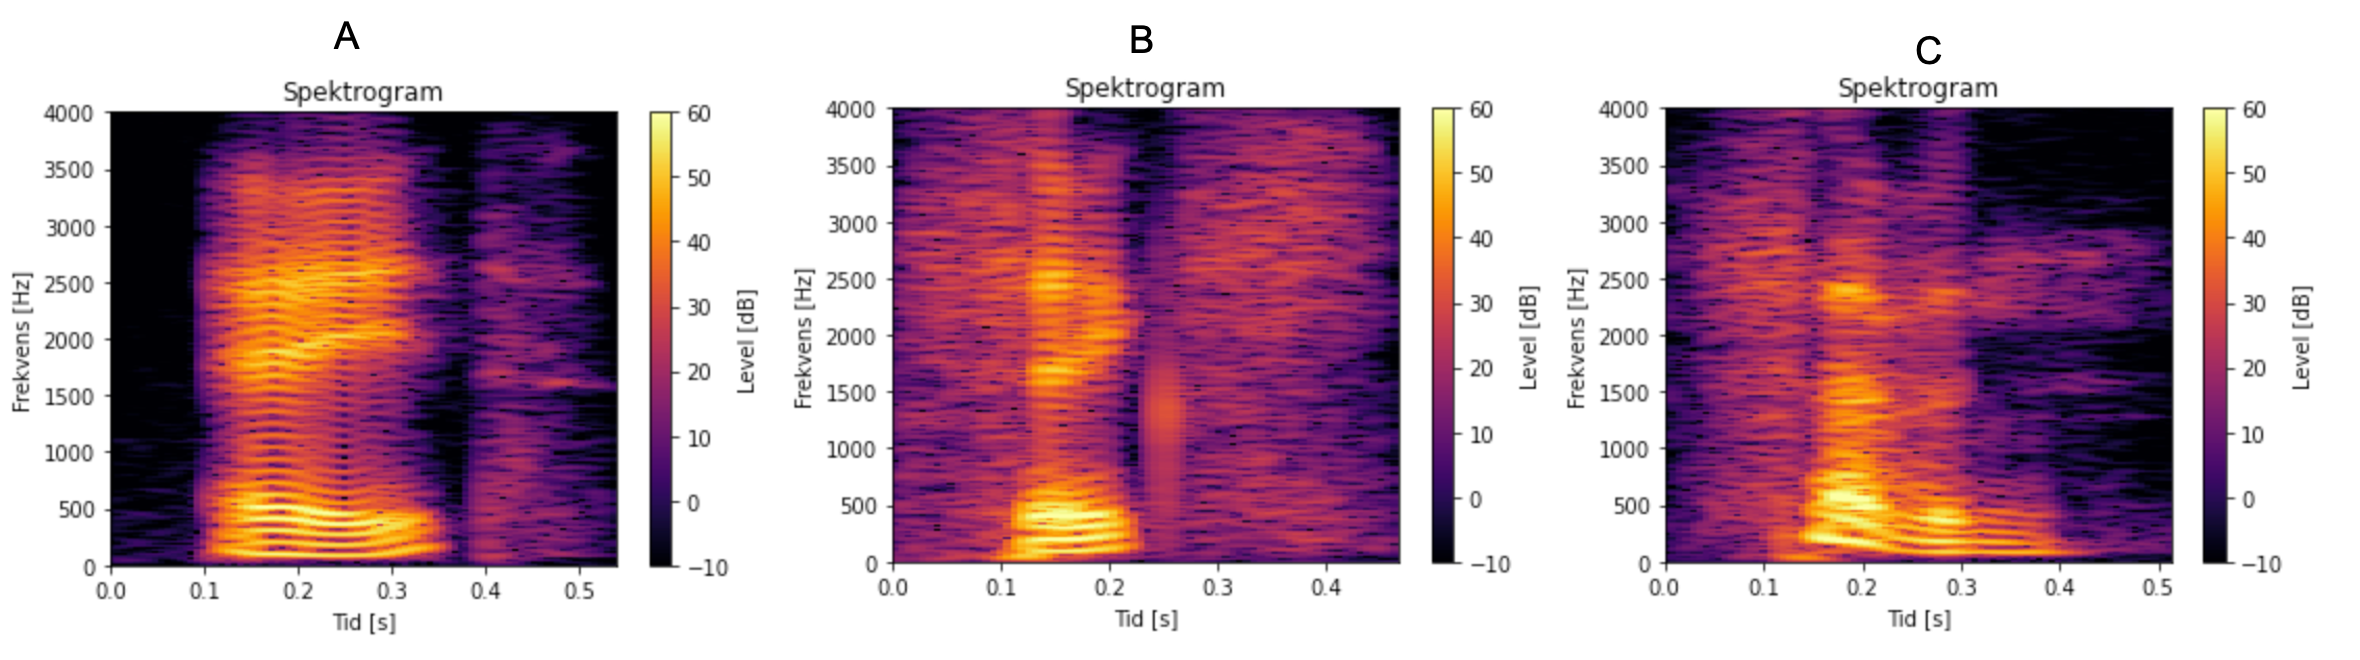


hint: prøv at identificer vokaler, frikativer, nasaler, og plosiver.

### STFT Ekstra øvelse: 
Spektrogrammet laves ved at opdele et signal i små stykker hvorefter disse stykker analyseres ved brug af fourier transformationen. Længden af disse stykker bestemmer præcisionen af spektrogrammet. Benyttes meget korte stykker bliver spektrogrammet meget præcist i forhold til tid, men mindre præcist i forhold til frekvens. Omvendt, hvis der bruges lange stykker bliver spektrogrammet meget præcist i frekvens, men mindre præcist i tid. Dette stykke kaldes en ramme, eller på engelsk: frame. 

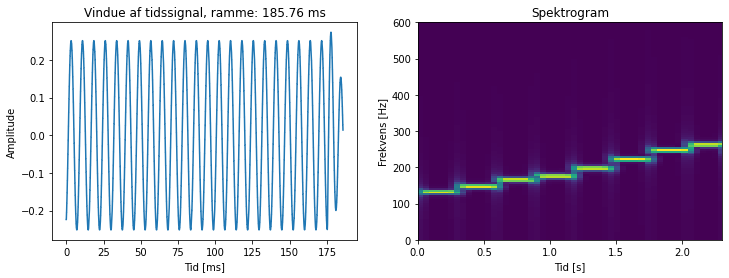

In [210]:
#@title Usikkerhed i tid og frekvens {run: "auto"}

audioDir = '/content/SRP2021/Audio/'
audioFiles = [f for f in os.listdir(audioDir) if f.endswith('wav')]

x,fs = utils.getAudio(audioDir + "sine_cScale.wav")
#x,fs = utils.getAudio(audioDir + "guitar_cScale.wav")
frameSize = "8192" #@param [128,256,512,1024,2048,4096,8192,16384]
frameSize = int(frameSize)

t = np.arange(frameSize)/fs

stft = spectrum.STFT(fs=fs,nperseg=frameSize,nfft=1)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"Vindue af tidssignal, ramme: {np.around(frameSize/fs * 1e3,2)} ms")
plt.plot(t*1e3,x[0,5000:5000+frameSize])
plt.ylabel("Amplitude")
plt.xlabel("Tid [ms]")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,(np.abs(X[0])))
plt.ylim([0,600])
plt.xlim([0,2.3])
plt.title("Spektrogram")
plt.xlabel("Tid [s]")
plt.ylabel("Frekvens [Hz]")
plt.show()

* Hvilken lyd afbilledes der på spektrogrammet?
* Hvad sker der hvis der er for få samples i en ramme?
* Hvorfor forringes tidsopløseligheden hvis rammen indenholde for mange samples?



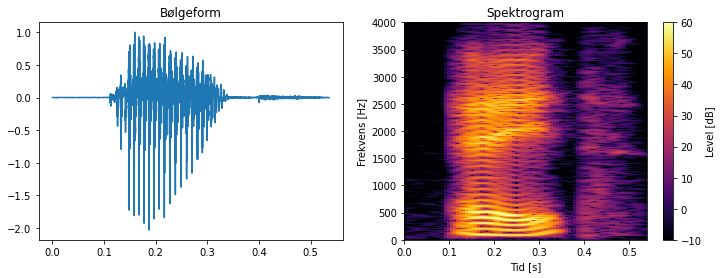

In [9]:
#@title Tal fra 0 til 9 {run: "auto"}

digit = "8" #@param ["6","7","8"]
digitFile = audioDir+audioFiles[int(digit)]

x,fs = utils.getAudio(digitFile)
x = processing.normalize().transform(x)
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(fs=fs,nperseg=512,nfft=4,noverlapratio=0.9)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x.T/x.max())
plt.title("Bølgeform")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=-10,vmax=60,cmap='inferno')
plt.ylim([0,4e3])
plt.title("Spektrogram")
plt.ylabel("Frekvens [Hz]")
plt.xlabel("Tid [s]")
cbar = plt.colorbar()
cbar.set_label("Level [dB]")
plt.show()

display(utils.play(x,fs))